### 19. Proces M/M/1 - zależność od tempa obsługi zdarzeń
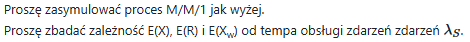

In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class QueueingSystem:
    def __init__(self, lambdaA, lambdaS, server_capacities=[-1], n_events=1_000_000): # -1 -> inf
        self.lambdaA = lambdaA # arrival rate
        self.lambdaS = lambdaS # service rate
        self.muA = 1 / lambdaA # mean inter-arrival time
        self.muS = 1 / lambdaS # mean service time

        self.n_servers = len(server_capacities)
        self.server_capacities = server_capacities
        self.n_events = n_events

        self.queues = [deque() for _ in range(self.n_servers)]
        self.server_busy_until = [0] * self.n_servers
        self.current_time = 0

        # \beta is the scale parameter, which is the inverse of the rate parameter \lambda = 1/\beta. 
        # The rate parameter is an alternative, widely used parameterization of the exponential distribution
        self.arrival_times = deque(np.cumsum(np.random.exponential(self.muA, self.n_events)))
        self.service_times = deque(np.random.exponential(self.muS, self.n_events))

        self.results = []

    def simulate(self):
        while self.arrival_times or any(len(queue) > 0 for queue in self.queues):
            self.handle_depatrure()

            while self.arrival_times and self.arrival_times[0] <= self.current_time: # 2x while self.arrival?
                self.current_time = self.arrival_times.popleft()
                service_time = self.service_times.popleft()
                self.handle_arrival(self.current_time, service_time)
            
            next_event_times = []
            for busy_until in self.server_busy_until:
                if busy_until > self.current_time:
                    next_event_times.append(busy_until)
            if self.arrival_times:
                next_event_times.append(self.arrival_times[0])

            

            if next_event_times:
                self.current_time = min(next_event_times)
            else:
                break

    def handle_arrival(self, arrival_time, service_time):
        # all servers are busy, add customer to the shortest queue
        queue_lengths = [len(q) for q in self.queues]
        min_queue_length = min(queue_lengths)
        min_queue_index = queue_lengths.index(min_queue_length)

        capacity = self.server_capacities[min_queue_index]
        if capacity == -1 or len(self.queues[min_queue_index]) < capacity:
            self.queues[min_queue_index].append((arrival_time, service_time))
        else:
            # reject the customer, queue is full
            pass

    def handle_depatrure(self):
        for i in range(self.n_servers):
            if self.server_busy_until[i] <= self.current_time:
                if self.queues[i]:
                    arrival_time, service_time = self.queues[i].popleft()
                    start_time = max(arrival_time, self.current_time)
                    self.server_busy_until[i] = start_time + service_time
                    self.results.append({
                        'Arrival time': arrival_time,
                        'Service start time': start_time,
                        'Service time': service_time,
                        'Departure time': start_time + service_time,
                        'Server': i
                    })

    def calculate_average_time_in_system(self):
        total_time_in_system = 0
        for result in self.results:
            time_in_system = result['Departure time'] - result['Arrival time']
            total_time_in_system += time_in_system
        average_time_in_system = total_time_in_system / len(self.results)
        return average_time_in_system

    def calculate_arrival_rate(self):
        total_arrivals = len(self.results)
        total_time = self.current_time
        arrival_rate = total_arrivals / total_time
        return arrival_rate

    def calculate_average_number_in_system(self):
        event_times = []
        for result in self.results:
            event_times.append((result['Arrival time'], 'arrival'))
            event_times.append((result['Departure time'], 'departure'))
        event_times.sort()

        num_in_system = 0
        last_event_time = 0
        area_under_curve = 0

        for time, event_type in event_times:
            time_interval = time - last_event_time
            area_under_curve += num_in_system * time_interval
            last_event_time = time

            if event_type == 'arrival':
                num_in_system += 1
            else:
                num_in_system -= 1

        total_time = self.current_time
        average_number_in_system = area_under_curve / total_time
        return average_number_in_system
    
    def calculate_average_number_in_queue(self):
        queue_events = []
        for result in self.results:
            arrival_time = result['Arrival time']
            start_time = result['Service start time']
            # only add to queue if the task actually waited
            if start_time > arrival_time:
                queue_events.append((arrival_time, 'queue_enter'))
                queue_events.append((start_time, 'queue_exit'))

        queue_events.sort()
        num_in_queue = 0
        last_event_time = 0
        area_under_curve = 0

        for time, event_type in queue_events:
            time_interval = time - last_event_time
            area_under_curve += num_in_queue * time_interval
            last_event_time = time

            if event_type == 'queue_enter':
                num_in_queue += 1
            else:
                num_in_queue -= 1

        total_time = self.current_time
        average_number_in_queue = area_under_curve / total_time
        return average_number_in_queue

λA: 0.06666666666666667 λS: 0.05
λA: 0.06666666666666667 λS: 0.05555555555555556
λA: 0.06666666666666667 λS: 0.061111111111111116
λA: 0.06666666666666667 λS: 0.06666666666666667
λA: 0.06666666666666667 λS: 0.07222222222222223
λA: 0.06666666666666667 λS: 0.07777777777777778
λA: 0.06666666666666667 λS: 0.08333333333333334
λA: 0.06666666666666667 λS: 0.08888888888888889
λA: 0.06666666666666667 λS: 0.09444444444444444
λA: 0.06666666666666667 λS: 0.1


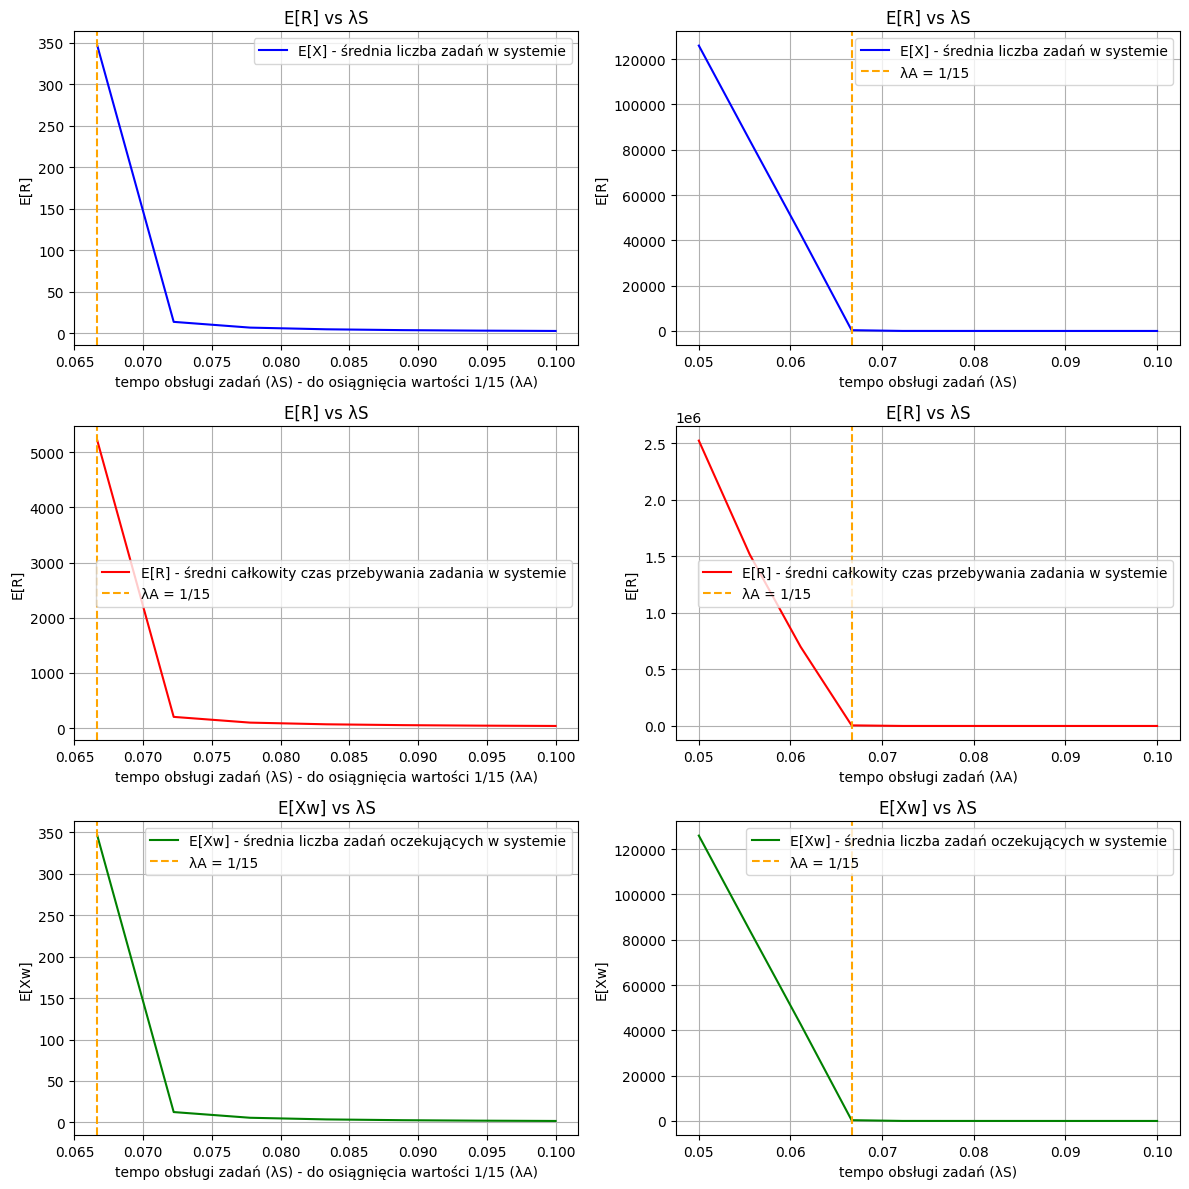

In [8]:
lambdaA = 1/15 # tempo nadchodzenia zadań - bez zmian (1/15) - mierzymy tu zależność od lambdaA
lambdaS = np.linspace(1/20, 1/10, 10) # tempo obsługi zadań 

E_X_values = []
E_R_values = []
E_Xw_values = []

for lS in lambdaS:
    mm1 = QueueingSystem(lambdaA, lS)
    print("λA:", lambdaA, "λS:", lS)
    mm1.simulate()
    average_time_in_system = mm1.calculate_average_time_in_system()
    average_number_in_system = mm1.calculate_average_number_in_system()
    average_number_in_queue = mm1.calculate_average_number_in_queue()

    E_X = average_number_in_system
    E_R = average_time_in_system
    E_Xw = average_number_in_queue

    E_X_values.append(E_X)
    E_R_values.append(E_R)
    E_Xw_values.append(E_Xw)

# --- 

plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.plot(lambdaS[3:], E_X_values[3:], 'b-', label='E[X] - średnia liczba zadań w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--')
plt.xlabel('tempo obsługi zadań (λS) - do osiągnięcia wartości 1/15 (λA)')
plt.ylabel('E[R]')
plt.title('E[R] vs λS')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(lambdaS, E_X_values, 'b-', label='E[X] - średnia liczba zadań w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--', label='λA = 1/15')
plt.xlabel('tempo obsługi zadań (λS)')
plt.ylabel('E[R]')
plt.title('E[R] vs λS')
plt.legend()
plt.grid(True)

# ---

plt.subplot(3, 2, 3)
plt.plot(lambdaS[3:], E_R_values[3:], 'r-', label='E[R] - średni całkowity czas przebywania zadania w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--', label='λA = 1/15')
plt.xlabel('tempo obsługi zadań (λS) - do osiągnięcia wartości 1/15 (λA)')
plt.ylabel('E[R]')
plt.title('E[R] vs λS')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(lambdaS, E_R_values, 'r-', label='E[R] - średni całkowity czas przebywania zadania w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--', label='λA = 1/15')
plt.xlabel('tempo obsługi zadań (λA)')
plt.ylabel('E[R]')
plt.title('E[R] vs λS')
plt.legend()
plt.grid(True)

# ---

plt.subplot(3, 2, 5)
plt.plot(lambdaS[3:], E_Xw_values[3:], 'g-', label='E[Xw] - średnia liczba zadań oczekujących w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--', label='λA = 1/15')
plt.xlabel('tempo obsługi zadań (λS) - do osiągnięcia wartości 1/15 (λA)')
plt.ylabel('E[Xw]')
plt.title('E[Xw] vs λS')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(lambdaS, E_Xw_values, 'g-', label='E[Xw] - średnia liczba zadań oczekujących w systemie')
plt.axvline(x=1/15, color='orange', linestyle='--', label='λA = 1/15')
plt.xlabel('tempo obsługi zadań (λS)')
plt.ylabel('E[Xw]')
plt.title('E[Xw] vs λS')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Wykresy wyglądają bardzo podobnie do tych z zadania 18, przy czym tutaj wartości E[Xw] - średnia liczba zadań oczekujących w systemie, E[R] - średni całkowity czas przebywania zadania w systemie oraz E[X] - średnia liczba zadań w systemie MALEJĄ wraz ze wzrostem tempa obsługi zadań (λS). Dlatego też poniższy komentarz będzie praktycznie identyczny.

Symulacje zostały przeprowadzone dla miliona zdarzeń.

Dla wartości tempa obsługi zadań (λS) WIĘKSZYCH od tempa nadchodzenia zadań (λA), E[Xw], E[R] oraz E[X] są prawie równe 0. Ma to sens - w końcu zadania zostają obsługiwane szybciej, niż przychodzą. (Może się jednak zdarzyć tak, że dwa zadania nadejdą tuż obok siebie i jednak jakaś kolejka się stworzy, lecz jak widać, jest to bardzo rzadkie, wartości są bliskie zera).

Gdy λS jest równe λA, E[Xw], E[R] oraz E[X] wynoszą odpowiednio około: 350, 5000, 350. Kolejki i czas przebywania zadania są zauważalnie powyżej zera. (Mogłoby się wydawać, że skoro tempo nadchodzenia zadań i ich wykonywania są równe, kolejki nie powinny się jeszcze tworzyć. Jednak ze względu na losowość, jest to bardzo mało prawdopodobne - zadania nadchodzą w różnych odstępach i mogą tworzyć się kolejki.) Dla nieskończenie długiego procesu, wartości oczekiwane E[Xw], E[R] oraz E[X] dążą do nieskończoności.

Dla wartości tempa obsługi zadań (λS) MNIEJSZYCH od tempa nadchodzenia zadań (λA), sytuacja zmienia się diametralnie. Serwer "nie wyrabia", ponieważ zadania nadchodzą częściej, niż są obsługiwane. Tworzą się gigantyczne kolejki, rośnie też czas przebywania w systemie. Przykładowo, dla λS = 1/15, E[Xw] - średnia liczba zadań oczekujących w systemie, wynosiła ~350, a dla λS =~ 1/16.36, zwiększyła się ona aż do ~42500.

Ogólnie, E[Xw] i E[X] przyjmują prawie identyczne wartości, ponieważ system kolejkowy ma tylko jeden serwer. Oznacza to, że tylko jedno zadanie może być w danym momencie wykonywane, a pozostałe muszą czekać w kolejce.
